In [1]:
from matplotlib import style, pylab
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from pprint import pprint
import datetime

from collections import Counter

from sklearn import svm, cross_validation, neighbors, linear_model
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from tqdm import tqdm

import bs4 as bs
import pickle
import requests
import math

import datetime as dt
import os 
import sys

pylab.rcParams['figure.figsize'] = (15, 10)
style.use('ggplot')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def save_tickers():
    resp = requests.get("https://en.wikipedia.org/wiki/OMX_Stockholm_30")
    soup = bs.BeautifulSoup(resp.text,"lxml")
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[2].text
        tickers.append(ticker)
    
    with open("omxs30.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

In [3]:
ans = save_tickers()

In [3]:
def get_stocks(reload_st=False):
    if reload_st:
        tickers = save_tickers()
    else:
        with open("omxs30.pickle","rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists("stock_omxs30"):
        os.makedirs("stock_omxs30")
    
    today = [int(x) for x in str(datetime.date.today()).split("-")]
    start = dt.datetime(2000,1,1)
    stop = dt.datetime(today[0],today[1],today[2])
    
    for ticker in tickers:
        if not os.path.exists("stock_dfs/{}.csv".format(ticker)) or reload_st:
            try:
                df = web.DataReader(ticker, 'yahoo', start, stop)
                df.to_csv("stock_omxs30/{}.csv".format(ticker))
                print ticker
            except:
                e = sys.exc_info()[0]
                print "err",e
        else:
            print("Already have: {}".format(ticker))
            

In [29]:
get_stocks(True)

ABB.ST
ALFA.ST
ASSA-B.ST
AZN.ST
ATCO-A.ST
ATCO-B.ST
BOL.ST
ELUX-B.ST
ERIC-B.ST
GETI-B.ST
HM-B.ST
INVE-B.ST
err <class 'pandas_datareader._utils.RemoteDataError'>
LUPE.ST
MTG-B.ST
NOKI.ST
NDA-SEK.ST
SAND.ST
SCA-B.ST
SEB-A.ST
SECU-B.ST
SKA-B.ST
SKF-B.ST
SSAB-A.ST
SHB-A.ST
SWED-A.ST
SWMA.ST
TEL2-B.ST
TLSN.ST
VOLV-B.ST


In [2]:
# import math

# def tmp():
#     df = pd.DataFrame()    
#     df['vals'] = [2,4,4,4,5,5,7,9]
#     df['deviation'] = (df['vals'] - df['vals'].mean())**2
    
#     print("Variance", df['deviation'].mean())
#     print("Standard Deviation", math.sqrt(df['deviation'].mean()))
#     print(df)
# tmp()

In [19]:
def add_features(df):
    for x in [5,10,20,30,50,75,100,150,300]:
        df['{}ma'.format(x)] = df["Adj Close"].rolling(window=x).mean()

    df['Close_min_Open'] = (df['Adj Close'] - df['Open'])
    df['High_min_Low'] = (df['High'] - df['Low'])    
    df['Close_min_Open_mean'] = df['Close_min_Open'].rolling(150).mean()
    df['High_min_Low_mean'] = df['High_min_Low'].rolling(150).mean()
    
    df['dev_open_close'] = (((df['Adj Close']-df['Open']) - (df['Adj Close']-df['Open']).mean())**2).rolling(window=10).sum()
    df['dev_max_min'] = (((df['High']-df['Low']) - (df['High']-df['Low']).mean())**2).rolling(window=10).sum()

    # DROPPING TABLES
#     del df['Close_min_Open']
#     del df['High_min_Low']
#     del df['Close']    
    
    df['Volume'] = df["Volume"].rolling(window=100).sum() #inaccurate

    df.dropna(inplace=True)
    
    df = (df - df.mean()) / (df.max() - df.min())    
    
    # 
    # Adds history to dataframe
    # * look into future = -i
    #
    hm_days = 4
    for i in range(1,hm_days+1):
        for feature in ["Adj Close", "dev_open_close", "dev_max_min"]:
            df["hist_{}_{}".format(feature,i)] = (df[feature].shift(i) - df[feature]) / df[feature] 
    
    #
    # Target value - what to predict
    #
    future_days = 30
    feature = "5ma"
    df["target"] = (df[feature].shift(-future_days) - df[feature]) #/ df[feature] 
    df.fillna(0, inplace=True)
    df["target"] = [round(x+.495) for x in df["target"]]
            
    return df

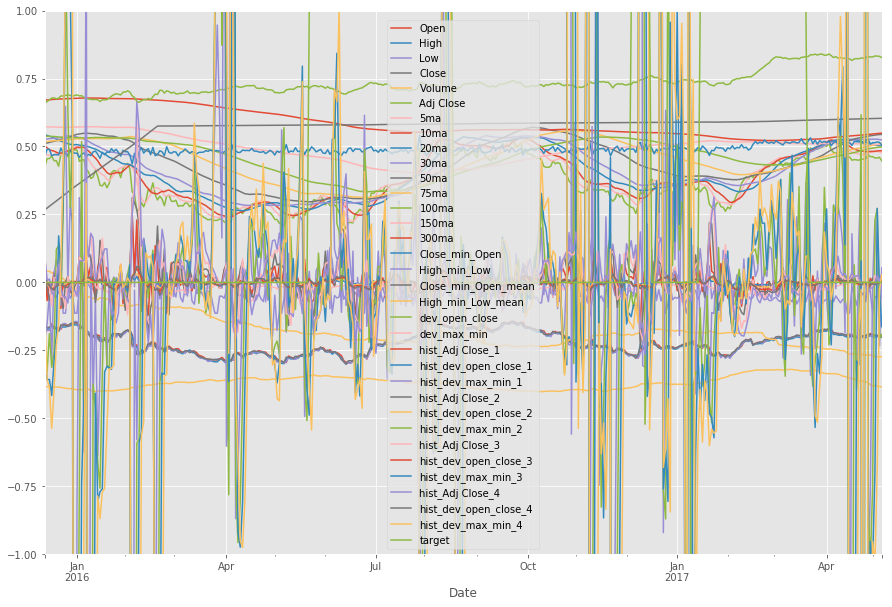

In [13]:
df = pd.read_csv('stock_omxs30/AZN.ST.csv', parse_dates=True, index_col=0)
df = add_features(df)

# df[["Adj Close","30ma", "dev_max_min","dev_open_close", "target"]][-1*365:].plot()
# df["High_min_Low_mean"][-365:].plot()

df[-365:].plot(ylim=[-1,1])
plt.show()

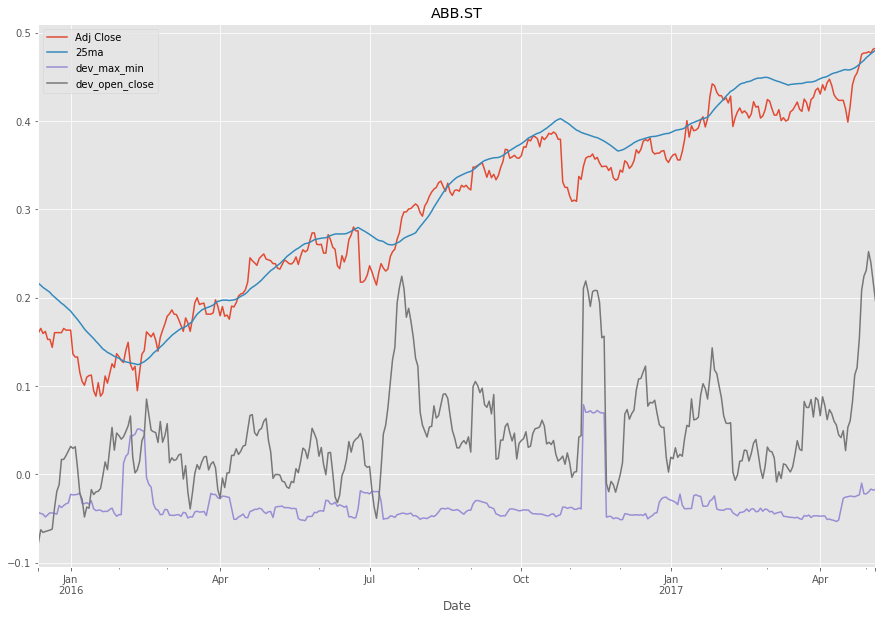

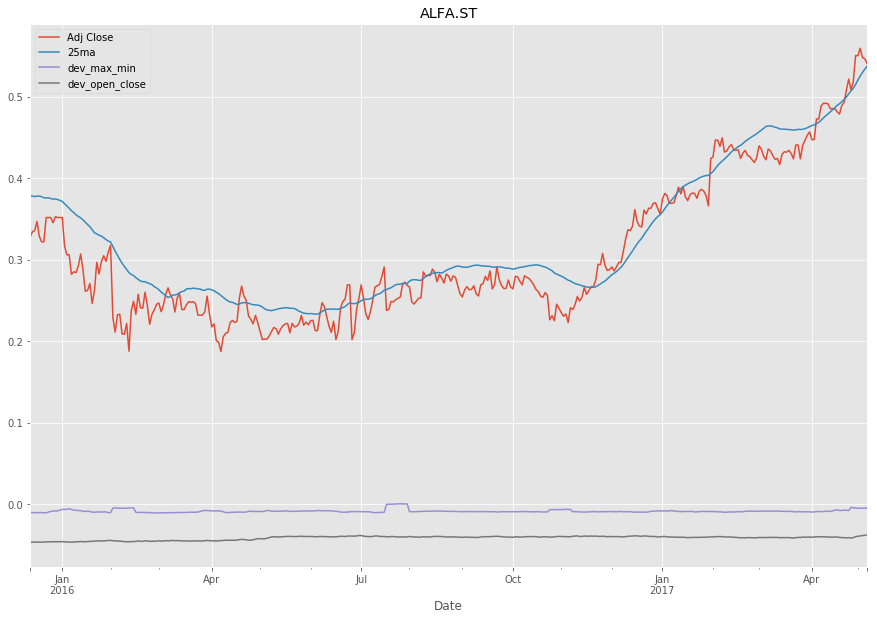

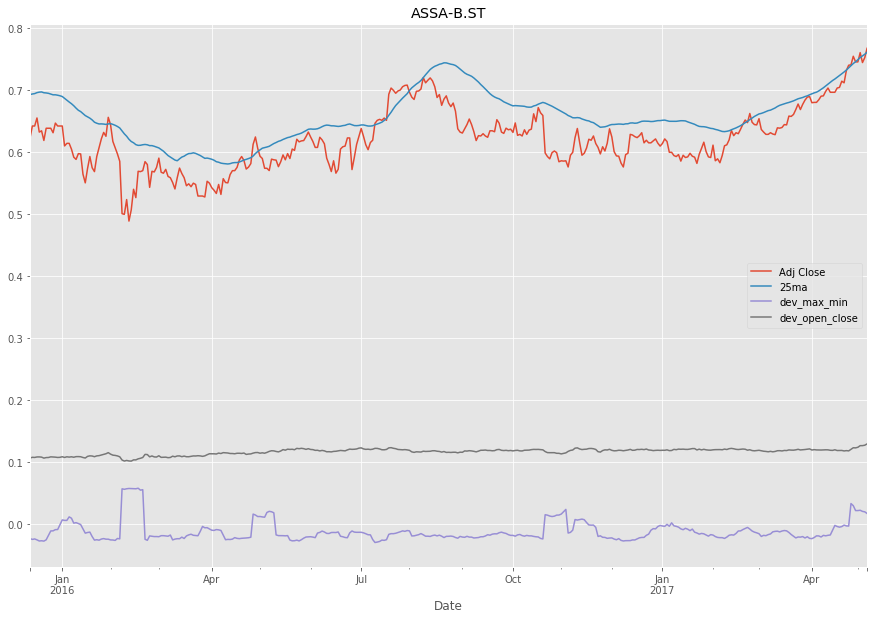

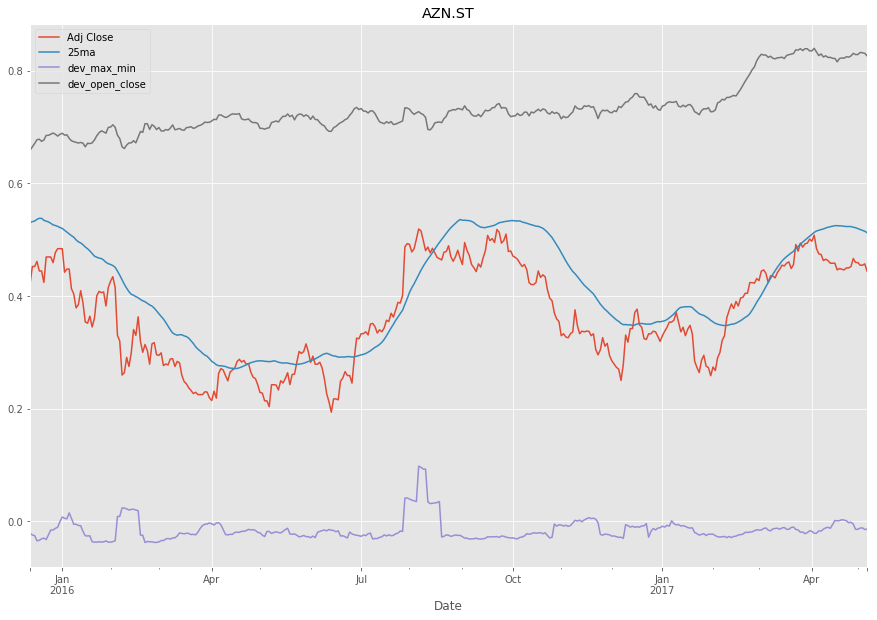

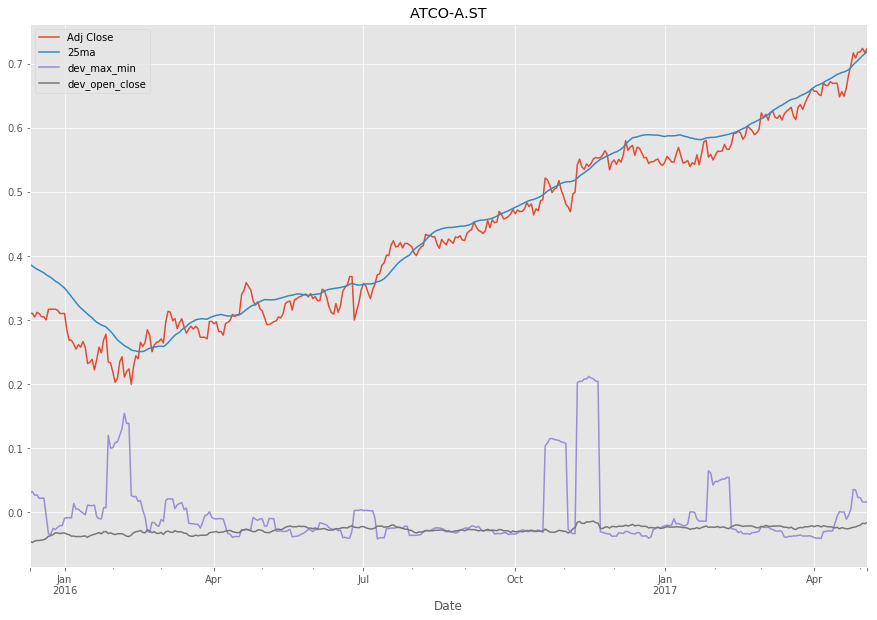

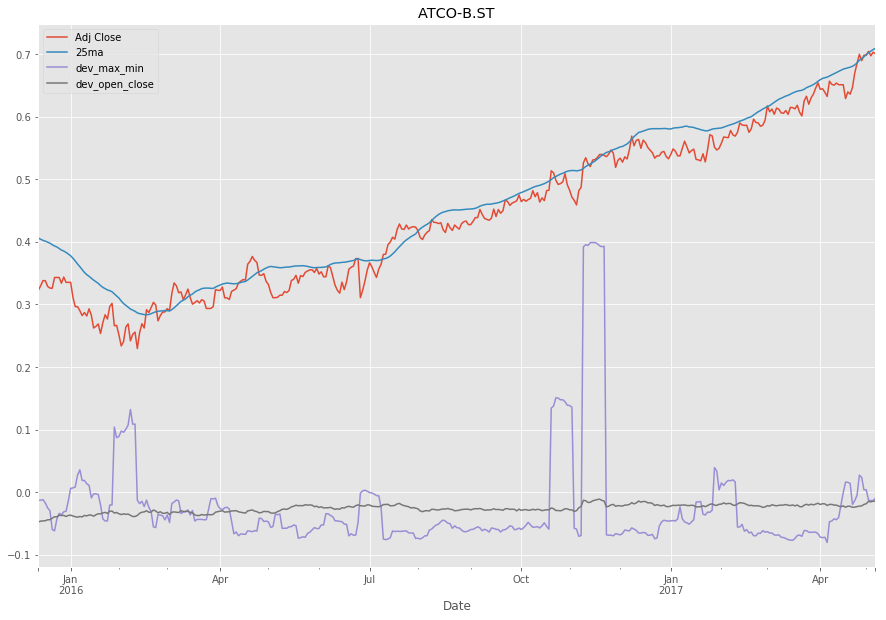

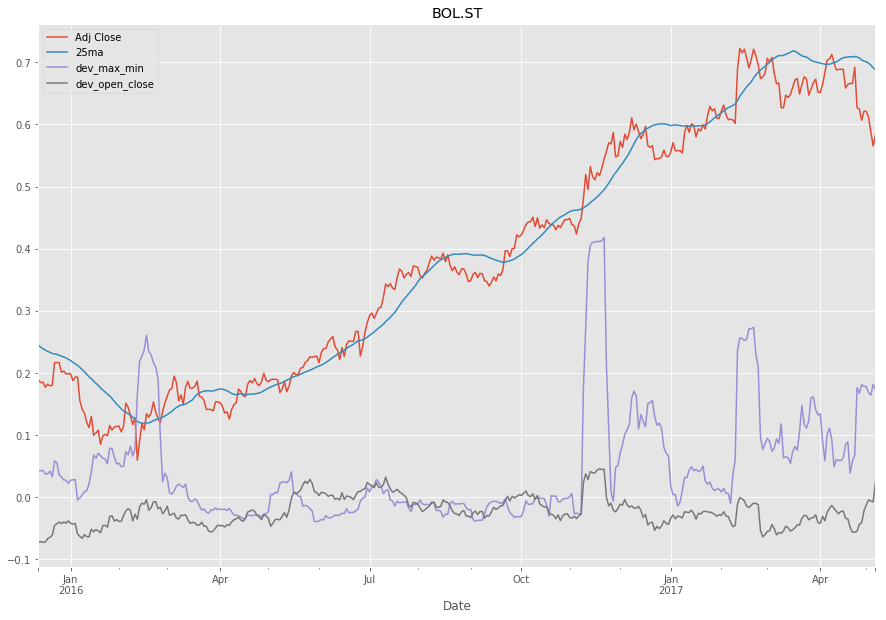

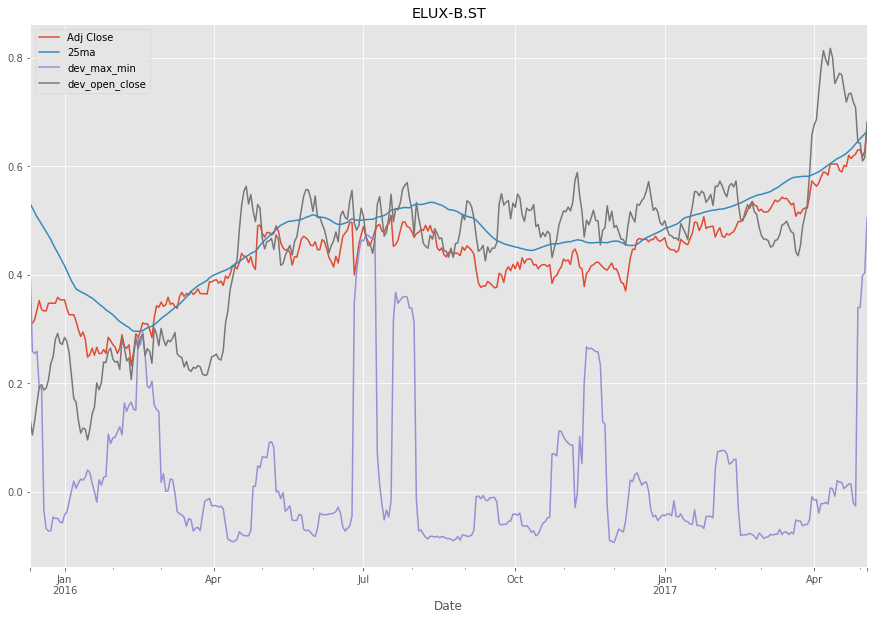

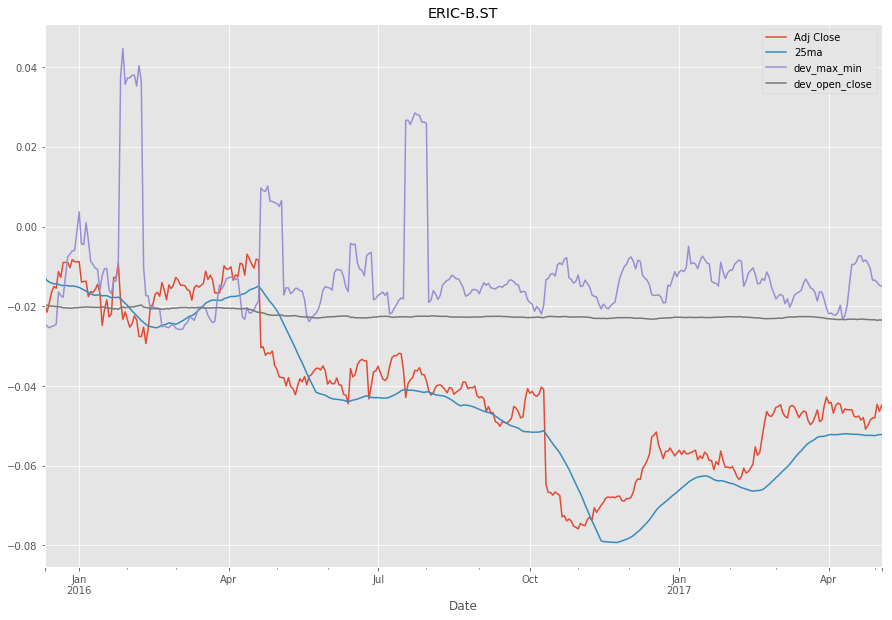

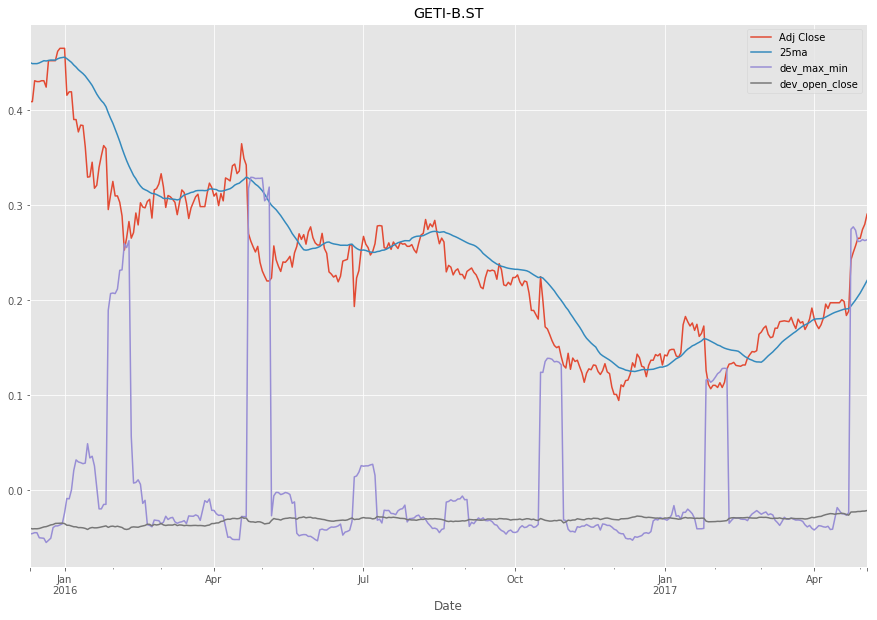

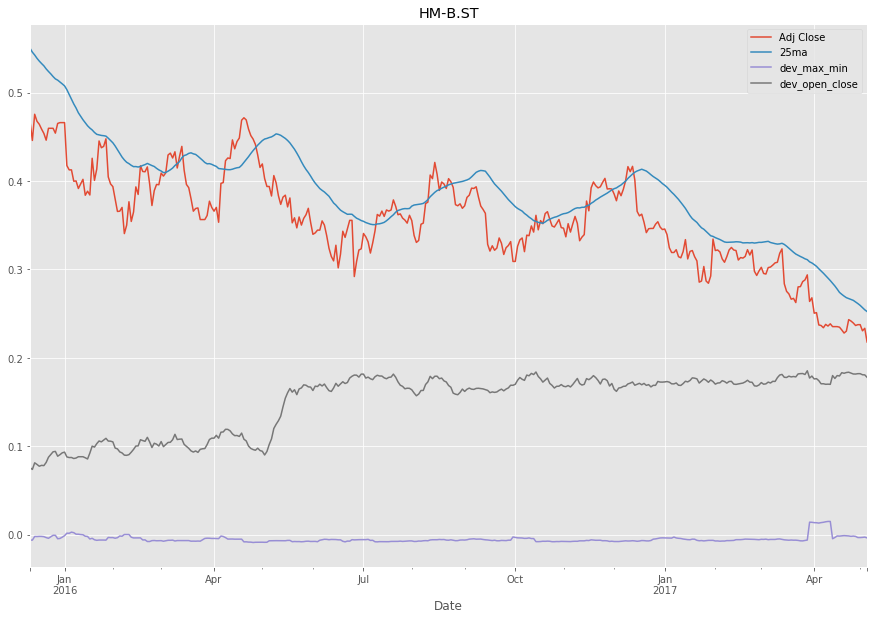

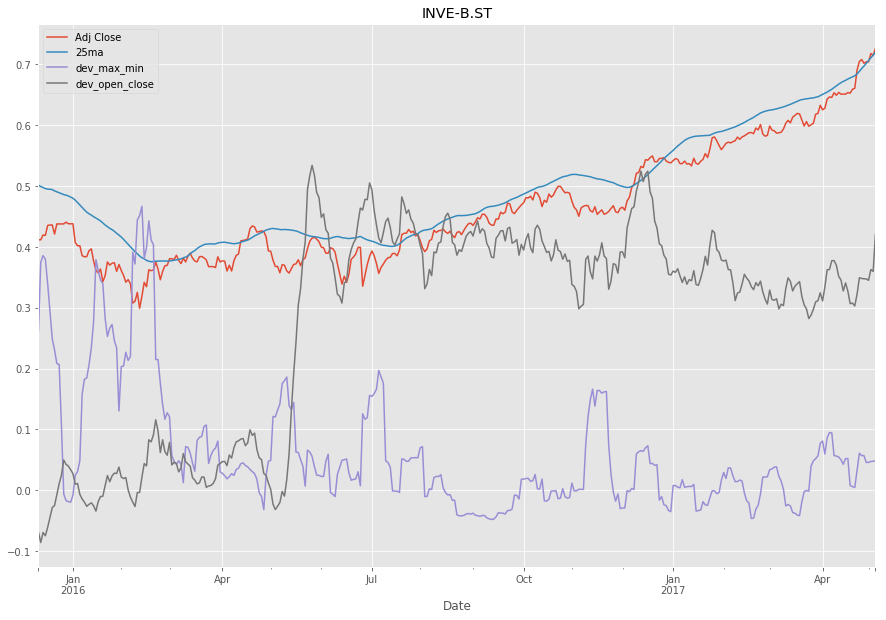

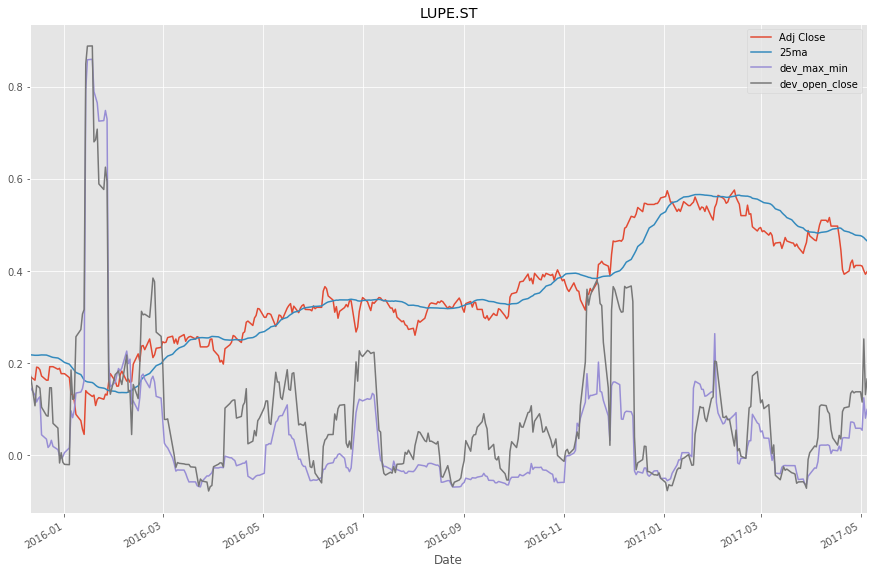

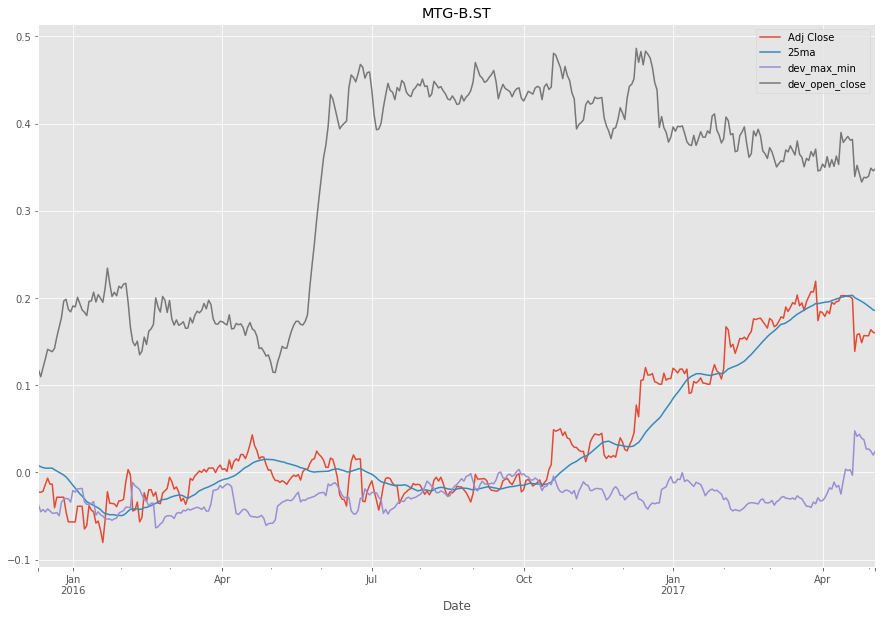

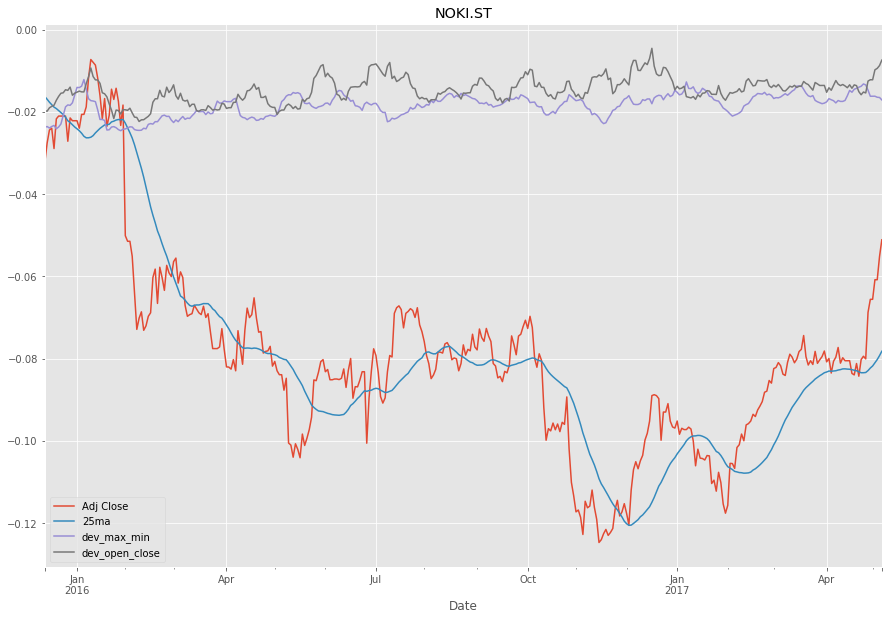

In [9]:
with open("omxs30.pickle","rb") as f:
    tickers = pickle.load(f)

for st in tickers:
    if os.path.exists("stock_omxs30/{}.csv".format(st)):
        df = pd.read_csv('stock_omxs30/{}.csv'.format(st),parse_dates=True,index_col=0)
        df = add_features(df)
        df[["Adj Close","25ma", "dev_max_min","dev_open_close"]][-365:].plot(title=st)

        if tickers.index(st)==15:
            break
plt.show()

In [7]:
def process_ticker(ticker):
    df = pd.read_csv("stock_omxs30/{}.csv".format(ticker), parse_dates=True, index_col=0)
    df = add_features(df)    
    return df

# df = process_ticker("AZN.ST")

In [8]:
def extract_featureset(ticker):
    df = process_ticker(ticker)
    target = df.pop("target").tolist()
    features = df.values.tolist()
    return([features, target])
    
# inp,out = extract_featureset('AZN.ST')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

def do_ml(ticker):
    X,y = extract_featureset(ticker)
    
#     X = X[5*-365:]
#     y = y[5*-365:]
        
#     X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.25)
    
    X_train = X[:int(len(X)*0.97)]
    X_test = X[int(len(X)*0.97):]
    y_train = y[:int(len(y)*0.97)]
    y_test = y[int(len(y)*0.97):]    
    
    
#("rfc",RandomForestClassifier()),
    
    clf = VotingClassifier([("LinearSVM", svm.SVC()),
                            ("Rforest", RandomForestClassifier()),
                            ("knn", neighbors.KNeighborsClassifier())])

#     clf = neighbors.KNeighborsClassifier()
#     clf = SGDClassifier()
#     clf = RandomForestClassifier()
#     clf = svm.SVC()
    
    clf.fit(X_train, y_train)    
    confidence = clf.score(X_test, y_test)
    prediction = clf.predict(X_test)
    
    print(ticker)
    print "prediction:", Counter(prediction)
    print "Accuracy:", confidence
    
    if clf.predict(X[:-1])[0]:
        action="Buy"
    else:
        action="Sell"
        
    print(action)
    print("---")
        
# do_ml("AZN.ST")

with open("omxs30.pickle","rb") as f:
    tickers = pickle.load(f)
for st in tickers:
    try:
        do_ml(st)
    except:
        print(st)
        print("---")

ABB.ST
prediction: Counter({0.0: 102, 1.0: 12})
Accuracy: 0.421052631579
Sell
---
ALFA.ST
prediction: Counter({0.0: 60, 1.0: 47})
Accuracy: 0.654205607477
Buy
---
ASSA-B.ST
prediction: Counter({1.0: 83, 0.0: 44})
Accuracy: 0.551181102362
Sell
---
AZN.ST
prediction: Counter({0.0: 84, 1.0: 40})
Accuracy: 0.701612903226
Buy
---
ATCO-A.ST
prediction: Counter({1.0: 115, 0.0: 9})
Accuracy: 0.596774193548
Sell
---
ATCO-B.ST
prediction: Counter({0.0: 77, 1.0: 50})
Accuracy: 0.433070866142
Sell
---
BOL.ST
prediction: Counter({1.0: 106, 0.0: 5})
Accuracy: 0.513513513514
Sell
---
ELUX-B.ST
prediction: Counter({0.0: 86, 1.0: 41})
Accuracy: 0.511811023622
Sell
---
ERIC-B.ST
prediction: Counter({0.0: 112, 1.0: 14})
Accuracy: 0.603174603175
Sell
---
GETI-B.ST
prediction: Counter({0.0: 78, 1.0: 49})
Accuracy: 0.48031496063
Sell
---
HM-B.ST
prediction: Counter({1.0: 111, 0.0: 16})
Accuracy: 0.173228346457
Sell
---
INVE-B.ST
prediction: Counter({1.0: 74, 0.0: 53})
Accuracy: 0.535433070866
Sell
---
KINV-